#todo: increase image resolution
IMPORT MODULES

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import mse_loss
import torchvision.models as models
import matplotlib.pyplot as plt
import random
import numpy as np
from utils import *

from IPython.display import Image, HTML, Markdown, clear_output
from io import BytesIO
import PIL
from time import sleep
from rich.progress import BarColumn, MofNCompleteColumn, Progress, TextColumn, TimeElapsedColumn, TimeRemainingColumn
from scipy.optimize import curve_fit



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)

if str(device) == "cuda":
  torch.set_default_tensor_type('torch.cuda.FloatTensor')


Device is cuda


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


Variables global au modele

In [3]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 4
IMG_SIZE = 128
IMG_LAYER_DEPTH = 12

CPOOL_SIZE = 1024



In [4]:
cnn = models.vgg19(weights='IMAGENET1K_V1').features.to(device)
cnn.requires_grad_(False)

# Initialize outputs dic
outputs = {}

# Hook definition

def save_output(name):

    # The hook signature
    def hook(module, module_in, module_out) -> None:
        outputs[name] = module_out
    return hook


# Define layers
layers = [1, 6, 11, 20, 29]
# Define weights for layers
layers_weights = [1/n**2 for n in [64, 128, 256, 512, 512]]

# Register hook on each layer with index on array "layers"
for layer in layers:
    handle = cnn[layer].register_forward_hook(save_output(layer))



def gramm(tnsr: torch.Tensor) -> torch.Tensor:
    # Computes Gram matrix for the input batch tensor.
    #    Args: tnsr (torch.Tensor): input tensor of the Size([B, C, H, W]).
    #    Returns:  G (torch.Tensor): output tensor of the Size([B, C, C]).
    b, c, h, w = tnsr.size()
    F = tnsr.view(b, c, h*w)
    G = torch.bmm(F, F.transpose(1, 2))
    G.div_(h*w)
    return G

def gram_loss(input: torch.Tensor, gramm_target: torch.Tensor, weight: float = 1.0):
    # Computes MSE Loss for 2 Gram matrices
    return weight * mse_loss(gramm(input), gramm_target)

def mse_loss_layers(input: torch.Tensor, target: torch.Tensor, weight: float = 1.0):
    return weight * mse_loss(input, target)

def to_grey_3ch(img):
     grey = torch.mean(img, axis=1).reshape(1, 1, 128, 128)
     return torch.cat([grey, grey, grey], axis=1)

def grab_plot():
  """Return the current Matplotlib figure as an image"""
  fig = plt.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  plt.close()
  return img


def live_plot(arr): # uint8 np array
  f = BytesIO()
  PIL.Image.fromarray(arr).save(f, 'jpeg', quality=95)
  display(Image(data=f.getvalue()), display_id="1")


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 165MB/s]


Image target : préparation et calcul des gramm targets pour les layers prédefinit

removing alpha chanel


/content/utils.py:88: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  t1 = tensor[0][:3].T.cpu().detach().numpy()


(-0.5, 127.5, 127.5, -0.5)

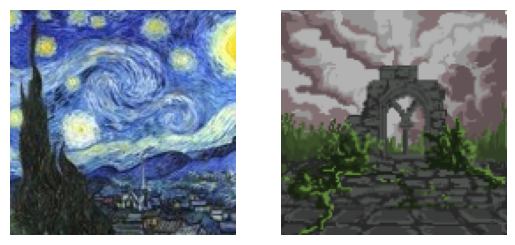

In [5]:


# Prepare texture data
image_tex = prep_img_file("vg_1.jpg", IMG_SIZE).to(device)  # à valeur dans 0-1
image_ref_rgb = prep_img_file("arch.png", IMG_SIZE).to(device)
image_ref = torch.mean(image_ref_rgb, axis=1).reshape(1, 1, 128, 128)

# Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
cnn(image_tex / 0.25)
gramm_targets = [gramm(outputs[key]) for key in layers]
cnn(to_grey_3ch(image_ref_rgb) / 0.25)
shape_targets = [outputs[key] for key in layers]

fig, (a1, a2) = plt.subplots(1, 2)
a1.imshow(to_img(image_tex))
a1.axis("off")
a2.imshow(to_img(image_ref_rgb))
a2.axis("off")


In [6]:
def loss(x):
    texture_loss = 0
    shape_loss = 0

    # Forward pass using target texture for get activations of selected layers (outputs). Calculate gram Matrix for those activations
    for img in x:
        rgb = img[:3].unsqueeze(0)

        cnn(rgb/0.25)
        synth_outputs = [outputs[key] for key in layers]

        for activations in zip(synth_outputs, gramm_targets, layers_weights):
            texture_loss += gram_loss(*activations)

        cnn(to_grey_3ch(rgb)/0.25)
        synth_outputs = [outputs[key] for key in layers]

        for activations in zip(synth_outputs, shape_targets, layers_weights):
            shape_loss += mse_loss_layers(*activations)

    return texture_loss, shape_loss


Fonction qui construit un DataLoader avec en entrée un train data

Neural network


In [7]:

class RecursiveNN(nn.Module):
    def __init__(self):
        super(RecursiveNN, self).__init__() # quece que ça fait cette merde ?

        self.ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]).to(device)
        self.sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).to(device)
        self.lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]]).to(device)


        self.cn1 = nn.Conv2d(4*(IMG_LAYER_DEPTH+1), 96, kernel_size = 1, padding = 0, stride = 1).to(device) # les biais ?  sont intégrés nn ?
        self.cn2 = nn.Conv2d(96, IMG_LAYER_DEPTH, kernel_size = 1, padding = 0, stride = 1, bias=False).to(device)
        self.cn2.weight.data.zero_()

        self.cpool = torch.rand(size = (CPOOL_SIZE+1, IMG_LAYER_DEPTH, IMG_SIZE, IMG_SIZE),dtype=torch.float32).to(device) # 1028 images de 128x128

    def forward(self,x0) :
        batch_ref = torch.cat([image_ref]*len(x0))
        x = torch.cat([x0, batch_ref], axis=1)

        """"from the paper"""
        b, ch, h, w = x.shape
        filters = torch.stack([self.ident, self.sobel_x, self.sobel_x.T, self.lap]).to(device)

        y = x.reshape(b*ch, 1, h, w)
        y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
        y = torch.nn.functional.conv2d(y, filters[:,None])
        y = y.reshape(b, -1, h, w)


        """end of paper"""


        out = self.cn2(F.relu(self.cn1(y)))

        return out + x0

    def render(model, it, width, height):

        x = torch.rand(size= (1, IMG_LAYER_DEPTH, width, height),dtype=torch.float32).to(device) # remplacer un des éléments du batch par une image rdm
        with torch.no_grad():
          for _ in range(0,it):
              x = model(x)
        return x


    def trainning(model, training_step):

        optim =  torch.optim.Adam(model.parameters(),lr = LEARNING_RATE)
        model.train() # met le modèle en mode entrainement je crois
        losses = []

        progress_bar = Progress(TextColumn("[progress.percentage]{task.percentage:>3.0f}%"), BarColumn(), MofNCompleteColumn(), TextColumn("•"), TimeElapsedColumn(), TextColumn("•"), TimeRemainingColumn())
        with progress_bar as p:
          for i in p.track(range(training_step)):

            indices = torch.randperm(len(model.cpool))[:4]
            x = model.cpool[indices]
            x[0] = torch.rand(size= (IMG_LAYER_DEPTH,128,128),dtype=torch.float32).to(device) # remplacer un des éléments du batch par une image rdm


            x = x.clone().detach()

            niter = torch.randint(low=32, high=64, size=(1,))
            for _ in range(0, niter):
                x = model(x)

            texture, shape = loss(x)
            L = texture + 0.0005*shape
            Ltot = L + torch.sum(torch.abs(x - x.clip(-1, 1))) / torch.numel(x)


            with torch.no_grad():
                Ltot.backward()
                for p in model.parameters():
                    p.grad /= (p.grad.norm()+1e-8)   # normalize gradients
                optim.step()
                optim.zero_grad()

            # update dataloader
            model.cpool[indices] = x.detach()


            losses += [np.log(Ltot.cpu().detach().numpy())]
            if i % 10 == 0 and i > 5:
              fit_func = lambda x, a, b, c: -a*np.log(x + b) + c
              params = curve_fit(fit_func, [*range(len(losses))], losses)
              [a, b, c] = params[0]
              plt.plot(fit_func(np.array([*range(training_step)]), a, b, c), '--')
              plt.plot(losses, '.', alpha=0.4)
              live_plot(grab_plot())
              sleep(0.1)


SETUP

TRAINNING

Output()

<ipython-input-7-6650b700256d>:26: UserWarning: Plan failed with a cudnnException: 
CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED 
(Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  y = torch.nn.functional.conv2d(y, filters[:,None])

<ipython-input-7-6650b700256d>:85: RuntimeWarning: invalid value encountered in log
  fit_func = lambda x, a, b, c: -a*np.log(x + b) + c

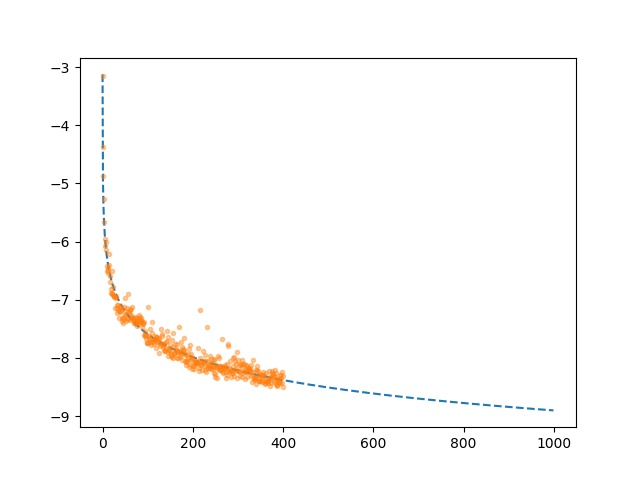

KeyboardInterrupt: 

In [8]:
model = RecursiveNN()
model.trainning(1000)

RENDER

(-0.5, 127.5, 127.5, -0.5)

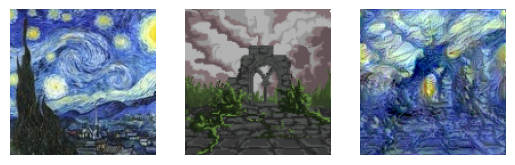

In [ ]:
finish = model.render(300, width=128, height=128)


fig, (a1, a2, a3) = plt.subplots(1, 3)
a1.imshow(to_img(image_tex))
a1.axis("off")
a2.imshow(to_img(image_ref_rgb))
a2.axis("off")
a3.imshow(to_img(finish))
a3.axis("off")
